In [6]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
%matplotlib widget

In [7]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose

        def observation_update(self, observation):
            for p in self.particles:
                p.observation_update(observation)

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + \
            ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [8]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn": 0.19, "no": 0.001, "on": 0.13, "oo": 0.2}):
        self.particles = [Particle(init_pose) for i in range(num)]

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def observation_update(self, observation):
        print(observation)

    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [9]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(
            self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

[(array([ 3.77949105, -0.94965206]), 1), (array([4.33238788, 0.81581731]), 2)]
[(array([ 3.69691922, -0.95018222]), 1), (array([4.34933557, 0.79519688]), 2)]
[(array([ 3.86130192, -1.03200997]), 1), (array([4.48824422, 0.82586641]), 2)]
[(array([4.4508249 , 0.81898074]), 2)]
[(array([4.38725189, 0.75277142]), 2)]
[(array([4.33952473, 0.71691575]), 2)]
[]
[(array([4.39608528, 0.68042417]), 2)]
[(array([4.02104951, 0.56499839]), 2)]
[(array([4.33126587, 0.61528867]), 2)]
[(array([4.22317221, 0.61530922]), 2)]
[(array([4.37686578, 0.55467789]), 2)]
[(array([4.00841456, 0.59161049]), 2)]
[(array([4.29822225, 0.46592751]), 2)]
[(array([4.15168382, 0.51770474]), 2)]
[(array([4.24054187, 0.54883517]), 2)]
[(array([4.10692179, 0.4654264 ]), 2)]
[(array([4.07114559, 0.47346233]), 2)]
[(array([4.05687085, 0.43807681]), 2)]
[(array([4.02741695, 0.43228698]), 2)]
[(array([3.97373628, 0.43526718]), 2)]
[(array([4.25088893, 0.36665045]), 2)]
[(array([3.89138178, 0.357691  ]), 2)]
[(array([4.04222559

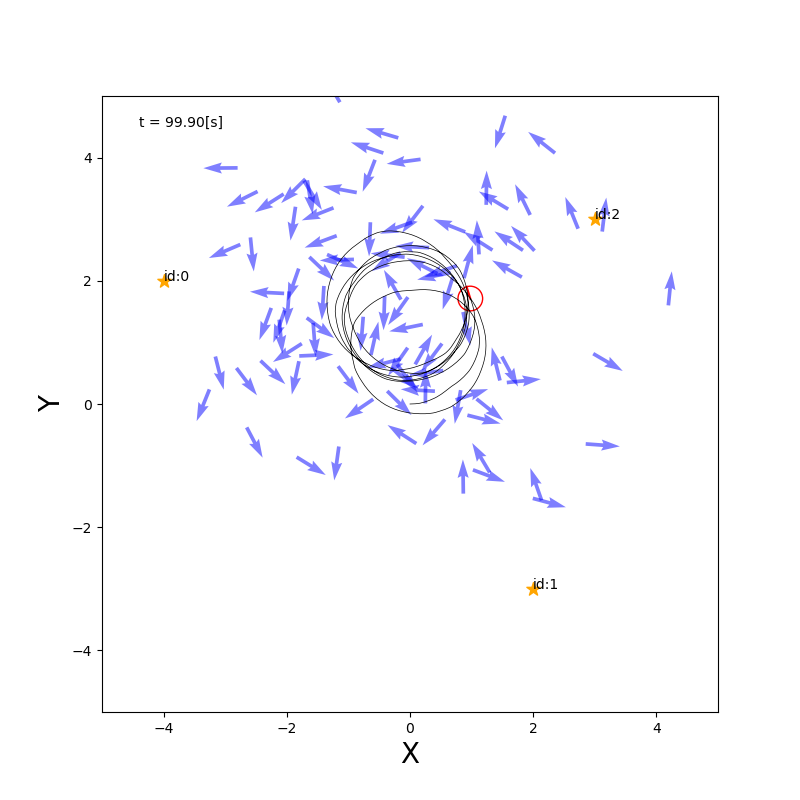

In [10]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)

    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

trial()